<img style="width:100%" src="../images/practical_xgboost_in_python_notebook_header.png" />

# Spotting Most Important Features
The following notebook presents how to distinguish the relative importance of features in the dataset.
Using this knowledge will help you to figure out what is driving the splits most for the trees and where we may be able to make some improvements in feature engineering if possible.

**What we'll be doing**:
- <a href="#libs">loading libraries</a> and <a href="#data">data</a>,
- <a href="#model">training a model</a>,
- <a href="#tree">knowing how a tree is represented</a>,
- <a href="#plot">plotting feature importance</a>

### Load libraries<a name='libs' />
The purpose of this step is to train simple model.
Let's begin with loading all libraries in one place.

In [1]:
%matplotlib inline

import xgboost as xgb
import seaborn as sns
import pandas as pd

sns.set(font_scale = 1.5)

### Load data<a name='data' />

Load agaricus dataset from file

In [2]:
dtrain = xgb.DMatrix('../data/agaricus.txt.train')
dtest = xgb.DMatrix('../data/agaricus.txt.test')

### Train the model<a name='model' />

Specify training parameters - we are going to use 5 stump decision trees with average learning rate.

In [3]:
# specify training parameters
params = {
    'objective':'binary:logistic',
    'max_depth':1,
    'silent':1,
    'eta':0.5
}

num_rounds = 5

Train the model. In the same time specify `watchlist` to observe it's performance on the test set.

In [4]:
# see how does it perform
watchlist  = [(dtest,'test'), (dtrain,'train')] # native interface only
bst = xgb.train(params, dtrain, num_rounds, watchlist)

[0]	test-error:0.11049	train-error:0.113926
[1]	test-error:0.11049	train-error:0.113926
[2]	test-error:0.03352	train-error:0.030401
[3]	test-error:0.027312	train-error:0.021495
[4]	test-error:0.031037	train-error:0.025487


### Representation of a tree<a name='tree' />

Before moving on it's good to understand the intuition about how trees are grown.

> *While building a tree is divided recursively several times (in this example only once) - this operation is called **split**. To perform a split the algorithm must figure out which is the best (one) feature to use*.

> *After that, at the bottom of the we get groups of observations packed in the **leaves**.*

> *In the final model, these leafs are supposed to be **as pure as possible** for each tree, meaning in our case that each leaf should be made of one label class.*

> *Not all splits are equally important. Basically the first split of a tree will have more impact on the purity that, for instance, the deepest split. Intuitively, we understand that the first split makes most of the work, and the following splits focus on smaller parts of the dataset which have been missclassified by the first tree.*

> *In the same way, in Boosting we try to optimize the missclassification at each round (it is called the loss). So the first tree will do the big work and the following trees will focus on the remaining, on the parts not correctly learned by the previous trees.*

> *The improvement brought by each split can be measured, it is the gain.*

> ~ Quoted from the Kaggle Tianqi Chen's Kaggle [notebook](https://www.kaggle.com/tqchen/otto-group-product-classification-challenge/understanding-xgboost-model-on-otto-data).

Let's investigate how trees look like on our case:

In [5]:
trees_dump = bst.get_dump(fmap='../data/featmap.txt', with_stats=True)

for tree in trees_dump:
    print(tree)

0:[odor=pungent] yes=2,no=1,gain=4000.53,cover=1628.25
	1:leaf=0.647758,cover=924.5
	2:leaf=-0.93331,cover=703.75

0:[odor=musty] yes=2,no=1,gain=1377.22,cover=1404.2
	1:leaf=-0.339609,cover=1008.21
	2:leaf=0.75969,cover=395.989

0:[gill-size=narrow] yes=2,no=1,gain=1210.77,cover=1232.64
	1:leaf=0.673358,cover=430.293
	2:leaf=-0.365203,cover=802.35

0:[stalk-surface-above-ring=smooth] yes=2,no=1,gain=791.959,cover=1111.84
	1:leaf=-0.277529,cover=765.906
	2:leaf=0.632881,cover=345.937

0:[odor=pungent] yes=2,no=1,gain=493.704,cover=981.683
	1:leaf=0.275961,cover=638.373
	2:leaf=-0.46668,cover=343.31



For each split we are getting the following details:

- which feature was used to make split,
- possible choices to make (branches)
- **gain** which is the actual improvement in accuracy brough by that feature. The idea is that before adding a new split on a feature X to the branch there was some wrongly classified elements, after adding the split on this feature, there are two new branches, and each of these branch is more accurate (one branch saying if your observation is on this branch then it should be classified as 1, and the other branch saying the exact opposite),
- **cover** measuring the relative quantity of observations concerned by that feature


### Plotting<a name='plot' />

Hopefully there are better ways to figure out which features really matter. We can use built-in function `plot_importance` that will create a plot presenting most important features due to some criterias. We will analyze the impact of each feature for all splits and all trees and visualize results.

See which feature provided the most gain:

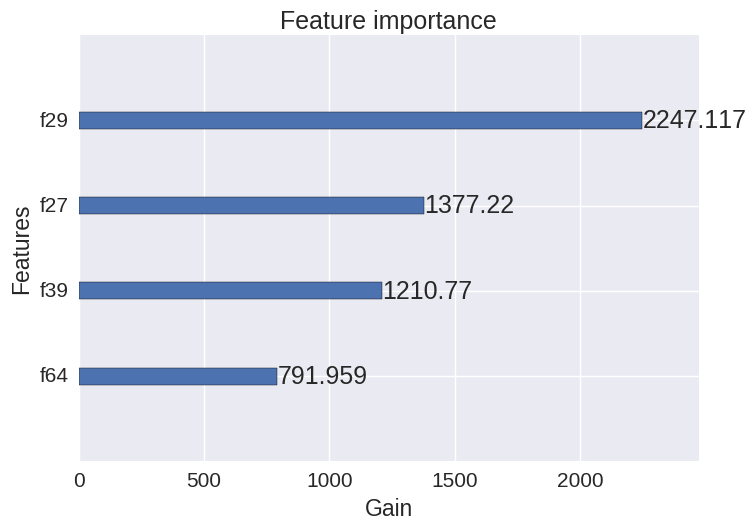

In [6]:
xgb.plot_importance(bst, importance_type='gain', xlabel='Gain')

We can simplify it a little bit by introducing a *F-score* metric.

> **F-score** - sums up how many times a split was performed on each feature. 

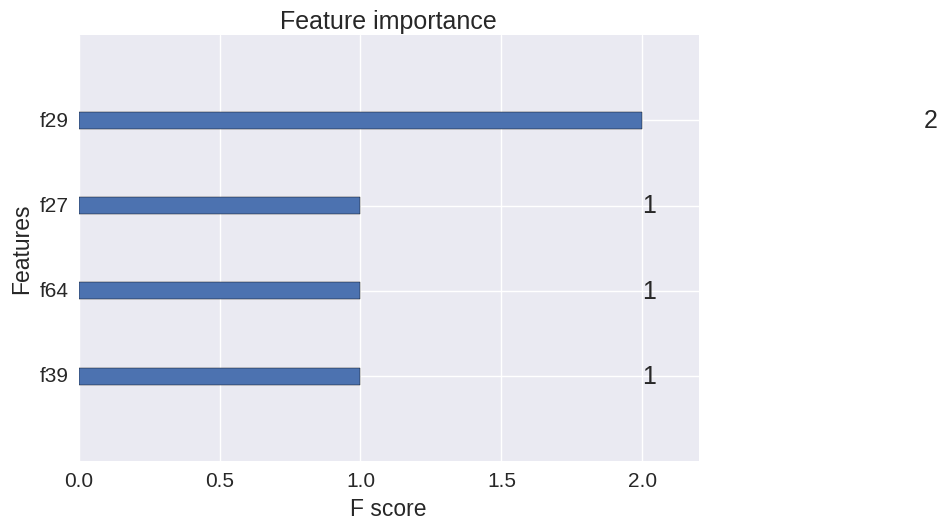

In [7]:
xgb.plot_importance(bst)

In case you want to visualize it another way, a created model enables convinient way of accessing the F-score.

In [8]:
importances = bst.get_fscore()
importances

{'f27': 1, 'f29': 2, 'f39': 1, 'f64': 1}

Now you can manipulate data in your own way

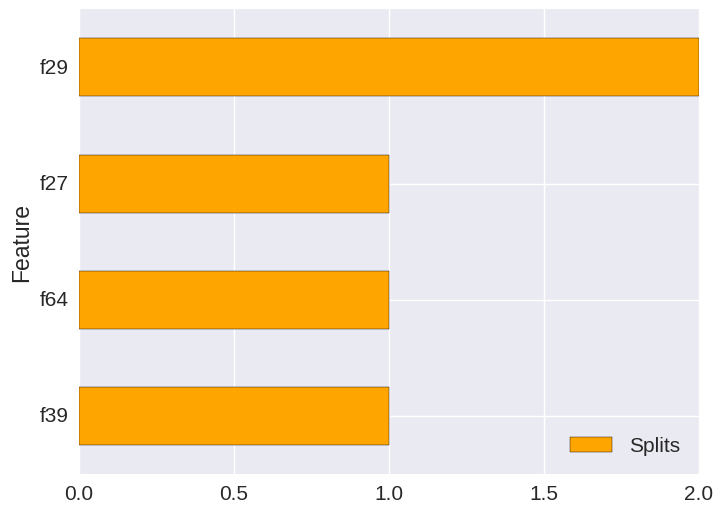

In [9]:
# create df
importance_df = pd.DataFrame({
        'Splits': list(importances.values()),
        'Feature': list(importances.keys())
    })
importance_df.sort_values(by='Splits', inplace=True)
importance_df.plot(kind='barh', x='Feature', figsize=(8,6), color='orange')